<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data exploration](#data_exploration)
3. [Data cleaning](#data_cleaning)
4. [Data preparation](#data_preparation)
5. [Benchmark model](#benchmark_model)<br>
6. [Feature engineering](#feature_engineering)
7. [Model training](#model_training)<br>
    7.1. [Decision Tree](#decision_tree)<br>
    7.2. [Random Forest](#random_forest)<br>
    7.3. [Comparing algorithm performances](#comparing_algorithm_performances)
8. [Tuning](#tuning)<br>

# 0. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [3]:
taxi_jan_2024= pd.read_parquet('data/yellow_tripdata_2024-01.parquet')
taxi_data= pd.concat([taxi_jan_2024])

In [5]:
print(taxi_data.shape)
taxi_data.head()

(2964624, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


# 2. Data exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

In [7]:
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [9]:
#keep meaniful columns for the task
taxi_data=taxi_data[['tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count',
                    'trip_distance','RatecodeID','PULocationID','DOLocationID',
                    'payment_type','total_amount']]

In [11]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,186,79,2,22.70
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,140,236,1,18.75
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,236,79,1,31.30
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,79,211,1,17.00
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,211,148,1,16.10


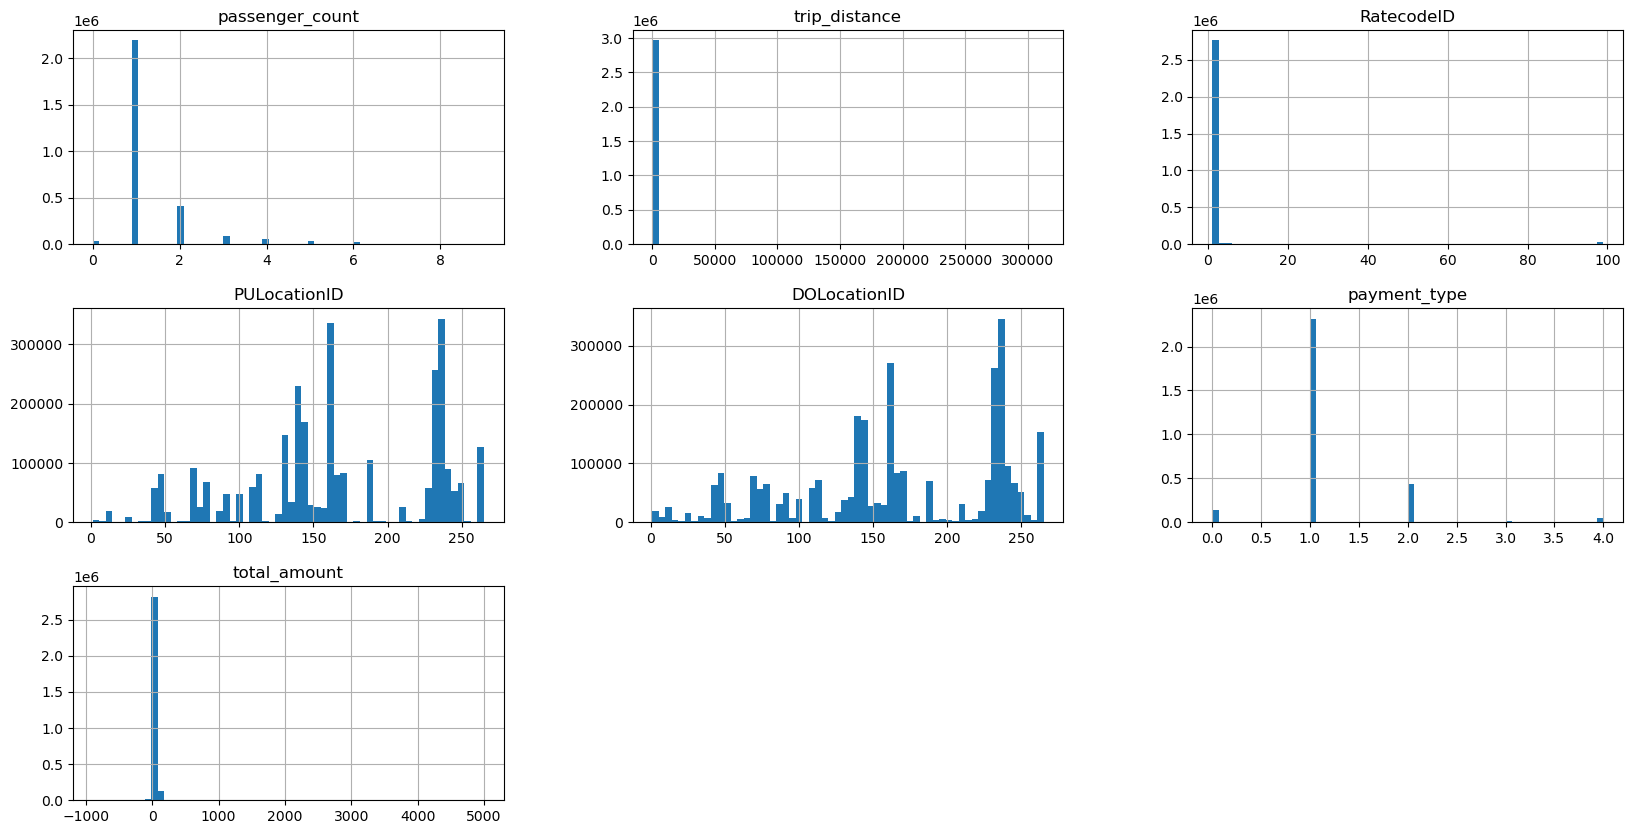

In [13]:
#visualize data in histograms
numeric_columns = taxi_data.select_dtypes(include=['number'])
numeric_columns.hist(figsize=(20,10),bins=60)
plt.show()

In [15]:
#notice outliers in ratecodeID, total_amount and trip_distance
taxi_data['RatecodeID'].value_counts()

RatecodeID
1.0     2663350
2.0       98713
99.0      28663
5.0       19410
3.0        7954
4.0        6365
6.0           7
Name: count, dtype: int64

<Axes: xlabel='index', ylabel='total_amount'>

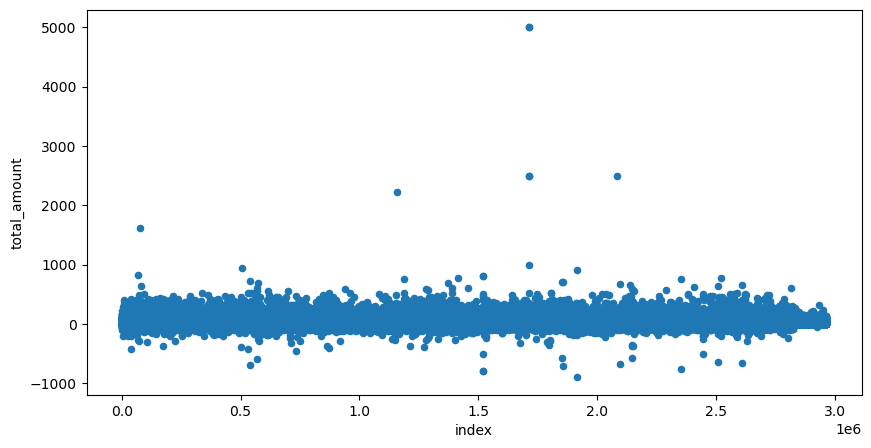

In [17]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount',x='index',figsize=(10,5))

<Axes: xlabel='index', ylabel='total_amount'>

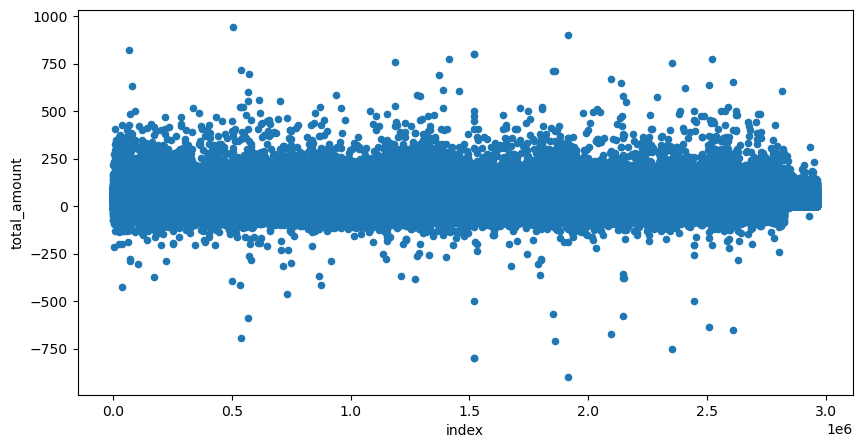

In [21]:
#values are manely under 1000$
taxi_data[taxi_data['total_amount']<1000].reset_index().plot(kind='scatter', y='total_amount',x='index',figsize=(10,5))

(35504, 9)


<Axes: xlabel='index', ylabel='total_amount'>

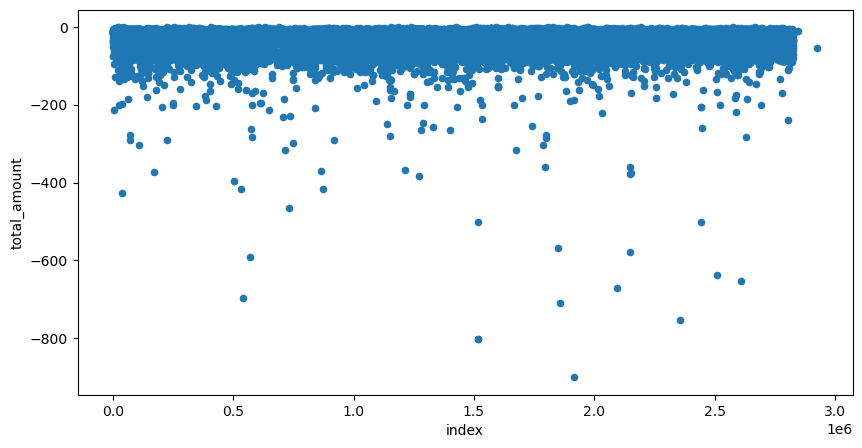

In [23]:
#notice negative values, how many are there?
print(taxi_data[taxi_data['total_amount']<0].shape)
taxi_data[taxi_data['total_amount']<0].reset_index().plot(kind='scatter', y='total_amount',x='index',figsize=(10,5))

In [25]:
#lets find some explanations
taxi_data[taxi_data['total_amount']<0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
99,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,1.0,249,232,4,-18.50
506,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,5.0,63,63,2,-34.25
536,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,1.0,249,113,4,-10.80
552,2024-01-01 00:42:02,2024-01-01 01:14:33,1.0,5.48,1.0,107,61,2,-38.10
682,2024-01-01 00:24:02,2024-01-01 01:10:32,1.0,8.74,1.0,90,225,4,-52.80


In [27]:
#there is some pattern in payment_type
taxi_data[taxi_data['total_amount']<0]['payment_type'].value_counts()

payment_type
4    21406
2     8326
3     5741
1       29
0        2
Name: count, dtype: int64

<Axes: >

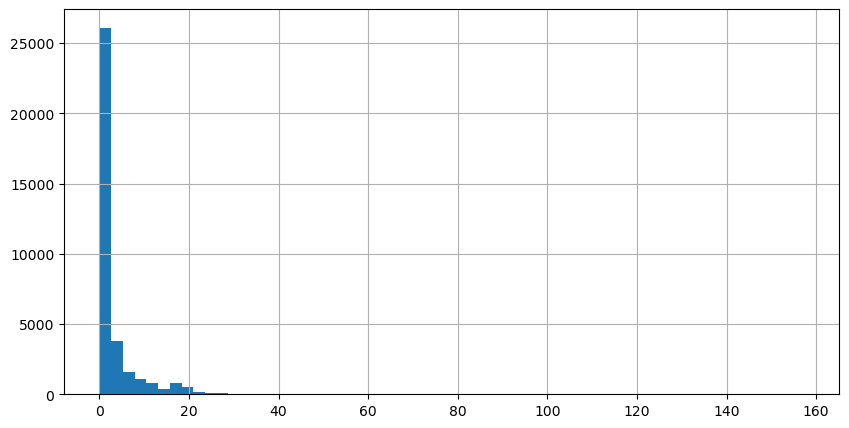

In [29]:
#what does the trip_distance looks like?
taxi_data[taxi_data['total_amount']<0]['trip_distance'].hist(bins=60, figsize=(10,5))

60% of negative amounts are dispute, so it's safe to remove them because it just gonna confuse the model.

In [33]:
#how about null values?
print(taxi_data[taxi_data['total_amount']==0].shape)
taxi_data[taxi_data['total_amount']==0].head()

(416, 9)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
854,2024-01-01 00:27:42,2024-01-01 00:28:49,1.0,0.2,1.0,239,143,4,0.0
29224,2024-01-01 10:01:27,2024-01-01 10:01:27,1.0,0.0,5.0,239,264,2,0.0
39191,2024-01-01 13:46:41,2024-01-01 14:12:06,1.0,0.0,99.0,42,216,1,0.0
39591,2024-01-01 13:03:22,2024-01-01 13:03:24,1.0,0.0,1.0,264,264,2,0.0
39592,2024-01-01 13:05:28,2024-01-01 13:05:35,1.0,0.0,1.0,193,193,2,0.0


In [35]:
taxi_data[taxi_data['total_amount']==0]['payment_type'].value_counts()

payment_type
1    129
4    128
3     83
2     65
0     11
Name: count, dtype: int64

<Axes: >

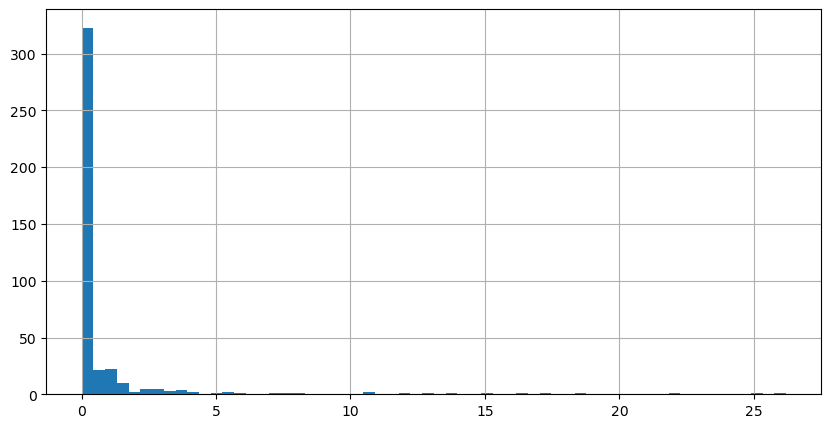

In [37]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [39]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].value_counts()

trip_distance
0.00     287
0.10      21
0.20       8
0.90       8
0.50       7
1.60       6
1.00       5
0.80       5
0.70       5
1.10       4
0.30       4
1.30       4
0.60       4
0.40       3
3.00       3
2.50       3
2.40       2
3.40       2
3.80       2
1.80       2
1.70       2
10.70      2
12.10      1
25.10      1
1.40       1
12.80      1
1.74       1
2.70       1
18.40      1
15.00      1
5.30       1
3.30       1
2.90       1
17.10      1
4.20       1
3.50       1
4.00       1
21.90      1
16.50      1
26.20      1
13.60      1
7.70       1
3.60       1
5.50       1
5.80       1
4.90       1
8.10       1
1.20       1
7.00       1
Name: count, dtype: int64

70% of trips with total_amount=0 have 0 trip distance, so it's safe to remove them.

<Axes: xlabel='index', ylabel='total_amount'>

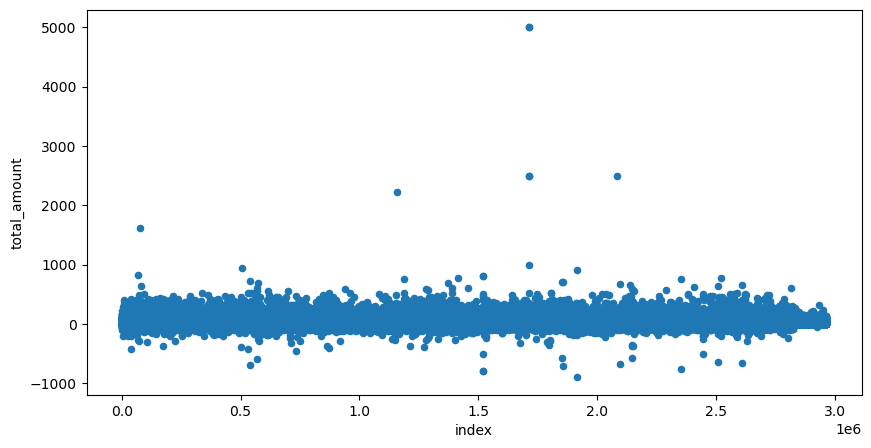

In [41]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [59]:
#let's see now how many positive outliers
taxi_data[taxi_data['total_amount']>200].shape

(2005, 9)

In [67]:
taxi_data['total_amount'].mean()

26.801504770925415

# 3. Data cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

# 5. Benchmark model <a id='benchmark_model'></a>
[Back to top](#table_of_contents)

# 6. Feature engineering <a id='feature_engineering'></a>
[Back to top](#table_of_contents)

# 7. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

## 7.1. Decision tree <a id='decision_tree'></a>

## 7.2. Random forest <a id='random_forest'></a>

## 7.3. Comparing algorithm performances <a id='comparing_algorithm_performances'></a>

# 8. Tuning <a id='tuning'></a>
[Back to top](#table_of_contents)